# Partie 4 : Analyse de Sentiment de Tweets avec BERT

Dans ce notebook, nous explorons l'analyse de sentiment de tweets en utilisant **BERT (Bidirectional Encoder Representations from Transformers)**, un modèle de deep learning à la pointe de la technologie pour le traitement du langage naturel. Le dataset **Sentiment140** contient 1,6 million de tweets étiquetés (positifs ou négatifs), ce qui en fait une excellente ressource pour entraîner notre modèle. Contrairement aux approches traditionnelles qui nécessitent une ingénierie de caractéristiques complexe, **BERT comprend le contexte bidirectionnel des mots**, ce qui est particulièrement utile pour capturer les subtilités linguistiques des tweets comme l'ironie, les abréviations et les expressions idiomatiques propres aux réseaux sociaux.

Concernant l'entrainement, le choix a été fait d'entrainer par optimisation de la variable de perte de validation `val_loss` avec en particulier un critère d'`EarlyStopping` au bout d'un certain nombre d'époques lancées (7, en l'ocurrence) afin de garantir une bonne généralisation ainsi qu'une limitation de l'overfitting.

Cependant, le critère qui sera retenu comme le plus important en raison de notre problématique métier est la `precision` car nous souhaitons plus que tout éviter les faux positifs (tweet prédit comme positif, alors qu'il sera mal reçu).

## Importation des bibliothèques

In [ ]:
from google.colab import drive
drive.mount('/content/drive')
import os
drive_folder=  "/content/drive/MyDrive/Colab_Notebooks/Project_7/notebooks"
os.chdir(drive_folder)
os.listdir()

Mounted at /content/drive


['content',
 'requirements_analyse_exploratoire.txt',
 'p07_01-notebook-analyse-exploratoire.ipynb',
 'requirements_bert.txt',
 'requirements_modele_simple.txt',
 'p07_02-notebook-modele-simple.ipynb',
 'requirements_modele_avance.txt',
 'p07_03-notebook-modele-avance.ipynb',
 'notebook-connexion-mlflow.ipynb',
 'p07_04-notebook-modele-bert.ipynb']

In [ ]:
!pip install mlflow boto3 dotenv --quiet

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 24.7/24.7 MB 47.2 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.9/1.9 MB 61.9 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 139.9/139.9 kB 11.9 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 247.0/247.0 kB 18.6 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 13.8/13.8 MB 85.8 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 147.8/147.8 kB 8.4 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 114.9/114.9 kB 11.0 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 85.0/85.0 kB 7.9 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 85.2/85.2 kB 8.4 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 741.4/741.4 kB 38.9 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 203.4/203.4 kB 13.7 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 65.6/65.6 kB 6.0 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 11

In [ ]:
import torch
print(f"PyTorch version: {torch.__version__}")
print(f"CUDA disponible: {torch.cuda.is_available()}")
if torch.cuda.is_available():
    print(f"Appareil CUDA: {torch.cuda.get_device_name(0)}")

PyTorch version: 2.6.0+cu124
CUDA disponible: True
Appareil CUDA: Tesla T4


In [ ]:
import os
import pickle
import subprocess
import re
import pandas as pd
import numpy as np
import torch
from torch.utils.data import Dataset, DataLoader
from torch.amp import GradScaler
from torch.optim import AdamW
from transformers import DistilBertTokenizer, DistilBertForSequenceClassification, get_scheduler
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score
from sklearn.metrics import confusion_matrix, classification_report, roc_curve, auc
import matplotlib.pyplot as plt
import seaborn as sns
from tqdm import tqdm
import html
import pickle
import zipfile
import requests
import json

In [ ]:
import mlflow
from mlflow.models.signature import infer_signature
from mlflow import MlflowClient
from mlflow.models.signature import ModelSignature
from mlflow.types import Schema, ColSpec, TensorSpec
from dotenv import load_dotenv
from google.colab import userdata
import mlflow.pytorch


# Charger les variables d'environnement depuis le fichier .env
load_dotenv(dotenv_path='../.env')

# Configuration de MLflow avec les variables d'environnement
mlflow_tracking_uri = os.getenv("MLFLOW_TRACKING_URI")
mlflow_s3_endpoint_url = os.getenv("MLFLOW_S3_ENDPOINT_URL")
aws_access_key_id = os.getenv("AWS_ACCESS_KEY_ID")
aws_secret_access_key = os.getenv("AWS_SECRET_ACCESS_KEY")

# Configuration explicite de MLflow
mlflow.set_tracking_uri(mlflow_tracking_uri)
print(f"MLflow Tracking URI: {mlflow_tracking_uri}")

# Configuration explicite des identifiants AWS
os.environ["MLFLOW_S3_ENDPOINT_URL"] = mlflow_s3_endpoint_url
os.environ["AWS_ACCESS_KEY_ID"] = aws_access_key_id
os.environ["AWS_SECRET_ACCESS_KEY"] = aws_secret_access_key
print("Identifiants AWS configurés")

# Créer l'expérience MLflow
mlflow.set_experiment("OC Projet 7")

#Création du dossier de sauvegarde du modèle
os.makedirs('content/bert-model/model', exist_ok=True)

MLflow Tracking URI: https://mlflow.greg-madman-nas.duckdns.org/
Identifiants AWS configurés


## 💾 Jeu de données : Sentiment140

Le jeu de données [Sentiment140 dataset with 1.6 million tweets](https://www.kaggle.com/datasets/kazanova/sentiment140) est une ressource majeure pour l'analyse de sentiment sur Twitter, comprenant **1,6 million de tweets** extraits via l'API Twitter. Ces tweets ont été automatiquement annotés selon leur polarité sentimentale, offrant une base solide pour développer des modèles de classification de sentiment.

Le jeu de données est organisé en 6 colonnes distinctes :

1. **target** : La polarité du sentiment exprimé dans le tweet.
   - 0 = sentiment négatif
   - 2 = sentiment neutre
   - 4 = sentiment positif
2. **ids** : L'identifiant unique du tweet (exemple : *2087*)
3. **date** : La date et l'heure de publication du tweet.
4. **flag** : La requête utilisée pour obtenir le tweet.
   - Exemple : *lyx*
   - Si aucune requête n'a été utilisée : *NO_QUERY*
5. **user** : Le nom d'utilisateur de l'auteur du tweet.
6. **text** : Le contenu textuel du tweet.

In [ ]:
%%time

# Define the URL and the local file path
url = "https://s3-eu-west-1.amazonaws.com/static.oc-static.com/prod/courses/files/AI+Engineer/Project+7%C2%A0-+D%C3%A9tectez+les+Bad+Buzz+gr%C3%A2ce+au+Deep+Learning/sentiment140.zip"
local_zip_path = "./content/data/sentiment140.zip"
extract_path = "./content/data"

if not os.path.exists(extract_path):

    # Create the directory if it doesn't exist
    os.makedirs(extract_path, exist_ok=True)

    # Download the zip file
    response = requests.get(url)
    with open(local_zip_path, 'wb') as file:
        file.write(response.content)

    # Extract the contents of the zip file
    with zipfile.ZipFile(local_zip_path, 'r') as zip_ref:
        zip_ref.extractall(extract_path)

    # Delete the zip file
    os.remove(local_zip_path)

CPU times: user 60 µs, sys: 9 µs, total: 69 µs
Wall time: 259 µs


In [ ]:
# Définir le chemin vers le fichier CSV
csv_file_path = './content/data/training.1600000.processed.noemoticon.csv'

## 🧠📚 Entraînement spécifique de BERT
Notre démarche pour la classification de sentiment avec des approches avancées comprend:

1. **Prétraitement des tweets**
   - Nettoyage
   - Tokenisation et lemmatisation
   - Remplacement des URLs et mentions par des tokens spéciaux

3. **Modèles testés**
   - BERT


3. **Évaluation et suivi**
   - Métriques: précision, accuracy, recall, F1-score, ROC-AUC
   - Tracking avec MLflow pour la reproductibilité et la comparaison

## Prétraitement des tweets

In [ ]:
# PRÉTRAITEMENT DES TWEETS
def preprocess_tweet_for_bert(tweet):
    """
    Prétraite un tweet pour l'entraînement BERT en conservant la structure naturelle
    du langage mais en normalisant certains éléments spécifiques aux réseaux sociaux.
    """
    # Vérifier si le tweet est une chaîne de caractères
    if not isinstance(tweet, str):
        return ""

    # Remplacer les URLs par un token spécial
    tweet = re.sub(r'https?://\S+|www\.\S+', '[URL]', tweet)

    # Remplacer les mentions par un token spécial
    tweet = re.sub(r'@\w+', '[USER]', tweet)

    # Normaliser les hashtags (conserver le hashtag comme entité)
    tweet = re.sub(r'#(\w+)', r'#\1', tweet)

    # Traiter le langage html
    tweet = html.unescape(tweet)

    # Normaliser les espaces multiples
    tweet = re.sub(r'\s+', ' ', tweet)

    # Supprimer les caractères non imprimables et certains caractères spéciaux inutiles
    tweet = re.sub(r'[^\x20-\x7E]', '', tweet)

    # Nettoyer les espaces en début et fin
    tweet = tweet.strip()

    return tweet

## Préparations des données

In [ ]:
# PRÉPARATION DES DONNÉES
def prepare_data(df, sample_size=50000, random_state=42):
    """
    Préparation des données pour l'entraînement BERT
    """
    # Remappage des labels (0=négatif, 4=positif) vers (0=négatif, 1=positif)
    df['target'] = df['target'].replace({0: 0, 4: 1})

    # Prétraitement des tweets
    print("Prétraitement des tweets...")
    df['processed_text'] = df['text'].apply(preprocess_tweet_for_bert)

    # Sélection d'un échantillon pour l'entraînement.
    # La distribution uniforme (50%/50%) des modalités ne posera pas problème pour le sous-échantillonnage.
    sample_data = df.sample(n=sample_size, random_state=random_state)

    # Division train/val/test
    train_val_texts, test_texts, train_val_labels, test_labels = train_test_split(
        sample_data['processed_text'].values,
        sample_data['target'].values,
        test_size=0.2,
        random_state=random_state
    )

    train_texts, val_texts, train_labels, val_labels = train_test_split(
        train_val_texts,
        train_val_labels,
        test_size=0.2,
        random_state=random_state
    )

    return {
        'train': {'texts': train_texts, 'labels': train_labels},
        'val': {'texts': val_texts, 'labels': val_labels},
        'test': {'texts': test_texts, 'labels': test_labels}
    }

In [ ]:
# CRÉATION D'UN DATASET PYTORCH
class TweetDataset(Dataset):
    def __init__(self, texts, labels, tokenizer, max_length=128):
        self.texts = texts
        self.labels = labels
        self.tokenizer = tokenizer
        self.max_length = max_length

    def __len__(self):
        return len(self.texts)

    def __getitem__(self, idx):
        text = str(self.texts[idx])
        label = self.labels[idx]

        # Tokenisation du texte
        encoding = self.tokenizer(
            text,
            add_special_tokens=True,
            max_length=self.max_length,
            truncation=True,
            padding='max_length',
            return_tensors='pt'
        )

        return {
            'input_ids': encoding['input_ids'].flatten(),
            'attention_mask': encoding['attention_mask'].flatten(),
            'label': torch.tensor(label, dtype=torch.long)
        }

## Fonctions d'entraînement

In [ ]:
import torch
from torch.cuda.amp import GradScaler
from sklearn.metrics import accuracy_score, precision_score, recall_score
from tqdm import tqdm

def train_model(
    model,
    train_loader,
    val_loader,
    test_loader,
    device,
    epochs=20,
    gradient_accumulation_steps=4,
    patience=7,
    lr=2e-5,
    lr_factor=0.2,
    min_lr=1e-6,
):
    """
    Train a BERT model with gradient accumulation,
    EarlyStopping on val_loss, and best model selection on val_precision.

    Args:
        model: The BERT model to train.
        train_loader: DataLoader for training data.
        val_loader: DataLoader for validation data.
        test_loader: DataLoader for test data.
        device: 'cuda' or 'cpu' for training.
        epochs: Maximum number of epochs to train.
        gradient_accumulation_steps: Number of steps for gradient accumulation.
        patience: Patience for EarlyStopping based on val_loss.
        lr: Initial learning rate.
        lr_factor: Factor to reduce learning rate in scheduler.
        min_lr: Minimum learning rate allowed.

    Returns:
        history: Training and validation history.
        test_metrics: Metrics on the test set.
    """

    best_val_precision = 0.0
    best_val_loss = float('inf')
    no_val_loss_improvement_count = 0

    optimizer = torch.optim.AdamW(model.parameters(), lr=lr, eps=1e-8)
    scheduler = torch.optim.lr_scheduler.ReduceLROnPlateau(
        optimizer, mode="min", factor=lr_factor, patience=2, min_lr=min_lr, verbose=True
    )
    scaler = GradScaler()

    history = {
        "train_loss": [],
        "val_loss": [],
        "train_accuracy": [],
        "val_accuracy": [],
        "train_precision": [],
        "val_precision": [],
        "val_recall": []
    }

    for epoch in range(epochs):
        print(f"\n=== Epoch {epoch + 1}/{epochs} ===")

        # Training phase
        model.train()
        train_loss, train_true, train_preds = 0.0, [], []

        for batch_idx, batch in enumerate(tqdm(train_loader, desc="Training")):
            input_ids = batch["input_ids"].to(device)
            attention_mask = batch["attention_mask"].to(device)
            labels = batch["label"].to(device)

            optimizer.zero_grad()

            # with autocast(enabled=torch.cuda.is_available()):
            with torch.amp.autocast(device_type='cuda' if torch.cuda.is_available() else 'cpu'):

                outputs = model(input_ids=input_ids, attention_mask=attention_mask, labels=labels)
                loss = outputs.loss / gradient_accumulation_steps

            scaler.scale(loss).backward()

            if (batch_idx + 1) % gradient_accumulation_steps == 0 or (batch_idx + 1) == len(train_loader):
                scaler.unscale_(optimizer)
                torch.nn.utils.clip_grad_norm_(model.parameters(), 1.0)
                scaler.step(optimizer)
                scaler.update()

            train_loss += loss.item() * gradient_accumulation_steps
            train_preds.extend(torch.argmax(outputs.logits, dim=1).cpu().numpy())
            train_true.extend(labels.cpu().numpy())

        avg_train_loss = train_loss / len(train_loader)
        train_accuracy = accuracy_score(train_true, train_preds)
        train_precision = precision_score(train_true, train_preds, zero_division=0)
        history["train_loss"].append(avg_train_loss)
        history["train_accuracy"].append(train_accuracy)
        history["train_precision"].append(train_precision)

        print(f"Train Loss: {avg_train_loss:.4f}, Train Accuracy: {train_accuracy:.4f}, Train Precision: {train_precision:.4f}")

        # Validation phase
        model.eval()
        val_loss, val_true, val_preds = 0.0, [], []

        with torch.no_grad():
            for batch in tqdm(val_loader, desc="Validation"):
                input_ids = batch["input_ids"].to(device)
                attention_mask = batch["attention_mask"].to(device)
                labels = batch["label"].to(device)

                outputs = model(input_ids=input_ids, attention_mask=attention_mask, labels=labels)
                loss = outputs.loss

                val_loss += loss.item()
                val_preds.extend(torch.argmax(outputs.logits, dim=1).cpu().numpy())
                val_true.extend(labels.cpu().numpy())

        avg_val_loss = val_loss / len(val_loader)
        val_accuracy = accuracy_score(val_true, val_preds)
        val_precision = precision_score(val_true, val_preds, zero_division=0)
        val_recall = recall_score(val_true, val_preds, zero_division=0)  # calcul recall ajouté

        history["val_loss"].append(avg_val_loss)
        history["val_accuracy"].append(val_accuracy)
        history["val_precision"].append(val_precision)
        history["val_recall"].append(val_recall)  # ajout dans l'historique

        print(f"Val Loss: {avg_val_loss:.4f}, Val Accuracy: {val_accuracy:.4f}, Val Precision: {val_precision:.4f}, Val Recall: {val_recall:.4f}")

        # Scheduler step on val_loss
        scheduler.step(avg_val_loss)

        # Save best model based on val_precision
        if val_precision > best_val_precision:
            best_val_precision = val_precision
            torch.save(model.state_dict(), "./content/bert-model/model/best_model.pth")
            print("New best model saved based on val_precision.")

        # EarlyStopping on val_loss
        if avg_val_loss < best_val_loss:
            best_val_loss = avg_val_loss
            no_val_loss_improvement_count = 0
        else:
            no_val_loss_improvement_count += 1
            print(f"No val_loss improvement. Patience: {no_val_loss_improvement_count}/{patience}")

        if no_val_loss_improvement_count >= patience:
            print("EarlyStopping activated.")
            break

    # Load best model
    model.load_state_dict(torch.load("./content/bert-model/model/best_model.pth"))
    print("Best model loaded for evaluation.")

    # Evaluate on test set
    test_metrics = evaluate_model(model, test_loader, device)

    return history, test_metrics

## Fonction d'évaluation

In [ ]:
# FONCTION D'ÉVALUATION
def evaluate_model(model, test_loader, device):
    """
    Évalue le modèle sur le jeu de test et retourne les métriques et prédictions
    """
    model.eval()
    test_preds, test_true = [], []
    test_probs = []

    with torch.no_grad():
        for batch in tqdm(test_loader, desc="Évaluation sur le jeu de test"):
            input_ids = batch['input_ids'].to(device)
            attention_mask = batch['attention_mask'].to(device)
            labels = batch['label'].to(device)

            outputs = model(
                input_ids=input_ids,
                attention_mask=attention_mask
            )

            # Récupération des prédictions et probabilités
            logits = outputs.logits
            probs = torch.nn.functional.softmax(logits, dim=1)
            preds = torch.argmax(logits, dim=1).cpu().numpy()
            true = labels.cpu().numpy()

            test_preds.extend(preds)
            test_true.extend(true)
            test_probs.extend(probs[:, 1].cpu().numpy())  # Probabilité de la classe positive

    # Calcul des métriques
    accuracy = accuracy_score(test_true, test_preds)
    precision = precision_score(test_true, test_preds)
    recall = recall_score(test_true, test_preds)
    f1 = f1_score(test_true, test_preds)

    # Matrice de confusion
    cm = confusion_matrix(test_true, test_preds)

    # Classification report
    report = classification_report(test_true, test_preds, target_names=['Négatif', 'Positif'])

    # Courbe ROC et AUC
    fpr, tpr, _ = roc_curve(test_true, test_probs)
    roc_auc = auc(fpr, tpr)

    # Regrouper toutes les métriques
    metrics = {
        'accuracy': accuracy,
        'precision': precision,
        'recall': recall,
        'f1': f1,
        'roc_auc': roc_auc,
        'fpr': fpr,
        'tpr': tpr,
        'confusion_matrix': cm,
        'classification_report': report,
        'predictions': test_preds,
        'true_labels': test_true,
        'probabilities': test_probs
    }

    return metrics

## Afficher la matrice de confusion

In [ ]:
# FONCTION POUR TRACER LA MATRICE DE CONFUSION
def plot_confusion_matrix(cm, class_names):
    """
    Tracer la matrice de confusion
    """
    plt.figure(figsize=(8, 6))
    sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', xticklabels=class_names, yticklabels=class_names)
    plt.xlabel('Prédictions')
    plt.ylabel('Valeurs réelles')
    plt.title('Matrice de confusion')

    # Save confusion matrix
    filename = f'content/bert-model/confusion_matrix.png'
    plt.savefig(filename)

    return plt.gcf()

## Fonction pour tracer la courbe ROC AUC

In [ ]:
# FONCTION POUR TRACER LA COURBE ROC
def plot_roc_curve(fpr, tpr, roc_auc, model_name, run_id=None):
    """
    Trace la courbe ROC et l'enregistre dans MLflow
    """
    plt.figure(figsize=(8, 6))
    plt.plot(fpr, tpr, label=f'ROC curve (area = {roc_auc:.3f})')
    plt.plot([0, 1], [0, 1], 'k--')
    plt.xlim([0.0, 1.0])
    plt.ylim([0.0, 1.05])
    plt.xlabel('Taux de faux positifs')
    plt.ylabel('Taux de vrais positifs')
    plt.title(f'Courbe ROC - {model_name}')
    plt.legend(loc="lower right")

    # Sauvegarder la figure localement
    filename = f'content/bert-model/roc_curve_{model_name}.png'
    plt.savefig(filename)

    # Enregistrer dans MLflow en utilisant l'exécution existante
    # if run_id:
    #     with mlflow.start_run(run_id=run_id):
    #         mlflow.log_figure(plt.gcf(), f"roc_curve_{model_name}.png")

    return plt.gcf()

## Fonction pour tracer l'historique d'entraînement

In [ ]:
# FONCTION POUR TRACER L'HISTORIQUE D'ENTRAÎNEMENT
def plot_training_history(history, model_name, run_id=None):
    """
    Trace l'historique d'entraînement du modèle et l'enregistre dans MLflow
    """
    fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(12, 5))

    # Tracer l'accuracy
    ax1.plot(history['train_precision'], label='train')
    ax1.plot(history['val_precision'], label='validation')
    ax1.set_title(f'Precision - {model_name}')
    ax1.set_xlabel('Epoch')
    ax1.set_ylabel('Precision')
    ax1.legend()

    # Tracer la loss
    ax2.plot(history['train_loss'], label='train')
    ax2.plot(history['val_loss'], label='validation')
    ax2.set_title(f'Loss - {model_name}')
    ax2.set_xlabel('Epoch')
    ax2.set_ylabel('Loss')
    ax2.legend()

    plt.tight_layout()

    # Sauvegarder la figure localement
    os.makedirs('content/bert-model', exist_ok=True)
    filename = f'content/bert-model/training_history_{model_name}.png'
    plt.savefig(filename)

    # Enregistrer dans MLflow en utilisant l'exécution existante
    if run_id:
        with mlflow.start_run(run_id=run_id):
            mlflow.log_figure(fig, f"training_history_{model_name}.png")

    return fig

## Enregistrement du modèle dans MLFlow

1. Définition de la signature du modèle pour MLflow
2. Démarrage d'une exécution MLflow avec un nom spécifique
3. Enregistrement des paramètres du modèle
4. Enregistrement des métriques de performance (accuracy, precision, recall, f1, roc_auc)
5. Création et enregistrement de visualisations (matrice de confusion, courbe ROC)
6. Enregistrement du rapport de classification
7. Sauvegarde locale du modèle BERT
8. Enregistrement du modèle PyTorch dans MLflow avec sa signature
9. Sauvegarde locale du tokenizer et enregistrement dans MLflow
10. Sauvegarde locale de la fonction de prétraitement (preprocessor) via pickle et enregistrement dans MLflow
11. Génération et enregistrement du fichier requirements.txt
10. Retourne l'**identifiant unique (Run ID)** de l'exécution MLflow qui vient d'être complétée, permettant de la référencer ultérieurement.

## Tableau des chemins des artefacts

| Artefact | Chemin local | Chemin MLflow |
|----------|--------------|---------------|
| Matrice de confusion | `content/bert-model/confusion_matrix.png` | `confusion_matrix_{model_name}.png` |
| Courbe ROC | `content/bert-model/roc_curve_{model_name}.png` | `roc_curve_{model_name}.png` |
| Historique d'entraînement | `content/bert-model/training_history_{model_name}.png` | `training_history_{model_name}.png` (si run_id fourni) |
| Rapport de classification | `content/bert-model/classification_report.txt` | Racine des artefacts |
| Modèle BERT | `content/bert-model/model/` | `model/` |
| Tokenizer | `content/bert-model/tokenizer/` | `tokenizer/` |
| Preprocessor | `content/bert-model/preprocessor/preprocessor.pkl` | `preprocessor/preprocessor.pkl` |
| Requirements | `content/bert-model/requirements.txt` | (Utilisé par MLflow comme dépendances du modèle) |


In [ ]:
# FONCTION POUR ENREGISTRER LE MODÈLE DANS MLFLOW
def log_model_to_mlflow(model, tokenizer, model_name, metrics, params=None):
    """
    Enregistre le modèle et ses performances dans MLflow, y compris la signature.
    Gère correctement les devices et la sérialisation JSON des métriques NumPy.
    Supprime input_example pour éviter l'avertissement de validation avec le flavor pytorch.

    Args:
        model (torch.nn.Module): Le modèle PyTorch (Hugging Face) entraîné.
        tokenizer: Le tokenizer Hugging Face associé au modèle.
        model_name (str): Un nom pour identifier ce modèle/cette exécution.
        metrics (dict): Un dictionnaire contenant les métriques de performance.
        params (dict, optional): Un dictionnaire des hyperparamètres utilisés. Defaults to None.

    Returns:
        str: L'ID de l'exécution MLflow.
    """
    class_names = ['Négatif', 'Positif']

    # --- Définir la signature du modèle ---
    sample_input_text = ["Ceci est un exemple de texte pour inférer la signature."]
    inputs = tokenizer(
        sample_input_text, return_tensors="pt", padding="max_length",
        truncation=True, max_length=128
    )
    try:
        model_device = next(model.parameters()).device
    except StopIteration:
        model_device = torch.device("cpu")
    except Exception:
        model_device = torch.device("cpu")

    inputs_on_device = None
    try:
        inputs_on_device = {k: v.to(model_device) for k, v in inputs.items()}
    except Exception as e:
        print(f"Error moving input tensors to device {model_device}: {e}. Skipping signature inference.")

    input_data_for_signature = {k: v.cpu().numpy() for k, v in inputs.items()} # For potential future use, still on CPU

    predictions = None
    signature = None
    if inputs_on_device:
        model.eval()
        with torch.no_grad():
            try:
                outputs = model(**inputs_on_device)
                if hasattr(outputs, 'logits'):
                    predictions = outputs.logits.cpu().numpy()
                elif isinstance(outputs, torch.Tensor):
                    predictions = outputs.cpu().numpy()
                else:
                    # Fallback attempt
                    for val in getattr(outputs, 'values', lambda: [])(): # Handle dicts or sequences
                         if isinstance(val, torch.Tensor):
                              predictions = val.cpu().numpy()
                              break

                if predictions is not None:
                    # Infer signature using the CPU numpy inputs and CPU numpy predictions
                    signature = infer_signature(input_data_for_signature, predictions)
                    print("Model signature inferred successfully.")
                else:
                    print("Warning: Could not extract prediction tensor for signature.")

            except Exception as e:
                print(f"Error during model prediction or signature inference: {e}")
    else:
         print("Skipping signature inference because input tensors could not be moved to model device.")
    # --- Fin de la définition de la signature ---

    # Démarrer une exécution MLflow
    with mlflow.start_run(run_name=f"Model_Bert-{model_name}") as run:

        # Enregistrer les paramètres du modèle
        if params:
            for key, value in params.items():
                mlflow.log_param(key, value)

        # Enregistrer les métriques de performance
        mlflow.log_metric("accuracy", metrics['accuracy'])
        mlflow.log_metric("precision", metrics['precision'])
        mlflow.log_metric("recall", metrics['recall'])
        mlflow.log_metric("f1", metrics['f1'])
        mlflow.log_metric("roc_auc", metrics['roc_auc'])

        mlflow.log_param("model_base", model_name)
        mlflow.set_tag("model_base", model_name)

        # Tracer et enregistrer la matrice de confusion
        fig_cm = plot_confusion_matrix(metrics['confusion_matrix'], class_names)
        mlflow.log_figure(fig_cm, f"confusion_matrix_{model_name}.png")

        # Tracer et enregistrer la courbe ROC
        fig_roc = plot_roc_curve(metrics['fpr'], metrics['tpr'], metrics['roc_auc'], model_name)
        mlflow.log_figure(fig_roc, f"roc_curve_{model_name}.png")

        # Enregistrer le rapport de classification
        report_path = f"content/bert-model/classification_report.txt"
        os.makedirs(os.path.dirname(report_path), exist_ok=True)
        with open(report_path, "w") as f:
            f.write(metrics['classification_report'])
        mlflow.log_artifact(report_path)


        # Sauvegarder le modèle localement
        model_path = f"content/bert-model/model"
        os.makedirs(model_path, exist_ok=True)
        try:
            model.save_pretrained(model_path)
            print("Model logged to MLflow artifact path 'model'.")
        except Exception as e:
            print(f"Warning: Failed to save or log model: {e}")


        # Enregistrer le tokenizer localement et sur MLFlow
        tokenizer_path = f"content/bert-model/tokenizer"
        os.makedirs(tokenizer_path, exist_ok=True)
        try:
            tokenizer.save_pretrained(tokenizer_path)
            mlflow.log_artifact(tokenizer_path)
            print("Tokenizer logged to MLflow artifact path 'tokenizer'.")
        except Exception as e:
            print(f"Warning: Failed to save or log tokenizer: {e}")


        # --- Sauvegarder la fonction preprocessor via pickle ---
        local_save_directory = "content/bert-model/preprocessor" # Attention au double "content" si c'est bien voulu
        local_pickle_filename = "preprocessor.pkl"
        local_pickle_filepath = os.path.join(local_save_directory, local_pickle_filename)
        # Sous-dossier cible dans les artefacts MLflow
        mlflow_artifact_subdir = "preprocessor"
        try:
            os.makedirs(local_save_directory, exist_ok=True)
            with open(local_pickle_filepath, "wb") as f_out:
                pickle.dump(preprocess_tweet_for_bert, f_out)
            mlflow.log_artifact(local_pickle_filepath, artifact_path=mlflow_artifact_subdir)
        except NameError:
            print(f"\nWarning: La fonction 'preprocess_tweet_for_bert' n'est pas définie. Impossible de la sauvegarder.\n")
        except Exception as e:
            print(f"\nWarning: Impossible de sauvegarder (pickle) ou logger la fonction de prétraitement : {e}\n")


        # Enregistrer le fichier requirements.txt
        requirements_path = "content/bert-model/requirements.txt"
        try:
            with open(requirements_path, 'w') as f:
                import sys
                subprocess.check_call([sys.executable, '-m', 'pip', 'freeze'], stdout=f)
        except subprocess.CalledProcessError as e:
            print(f"Warning: Failed to generate requirements.txt: {e}. Logging without pip_requirements.")
            requirements_path = None
        except Exception as e:
             print(f"An unexpected error occurred during requirements generation: {e}")
             requirements_path = None

        # --- Enregistrer le modèle PyTorch sans input_example ---
        try:
            mlflow.pytorch.log_model(
                pytorch_model=model,
                artifact_path="model",  # Simplement "model" pour être cohérent
                signature=signature,
                pip_requirements=requirements_path if requirements_path else None
            )
            print(f"Model '{model_name}' logged to MLflow artifact path 'model_{model_name}'.")
        except Exception as e:
            print(f"FATAL: Error logging PyTorch model to MLflow: {e}")
            return None

        print(f"MLflow logging attempt finished for run '{run.info.run_id}'.")

        return run.info.run_id

In [ ]:
# FONCTION POUR ENREGISTRER LE MODÈLE DANS MLFLOW
def log_model_to_mlflow(model, tokenizer, model_name, metrics, history=None, params=None):
    """
    Enregistre le modèle et ses performances dans MLflow, y compris la signature.
    Gère correctement les devices et la sérialisation JSON des métriques NumPy.
    Supprime input_example pour éviter l'avertissement de validation avec le flavor pytorch.

    Args:
        model (torch.nn.Module): Le modèle PyTorch (Hugging Face) entraîné.
        tokenizer: Le tokenizer Hugging Face associé au modèle.
        model_name (str): Un nom pour identifier ce modèle/cette exécution.
        metrics (dict): Un dictionnaire contenant les métriques de performance.
        params (dict, optional): Un dictionnaire des hyperparamètres utilisés. Defaults to None.

    Returns:
        str: L'ID de l'exécution MLflow.
    """
    class_names = ['Négatif', 'Positif']

    # --- Définir la signature du modèle ---
    sample_input_text = ["Ceci est un exemple de texte pour inférer la signature."]
    inputs = tokenizer(
        sample_input_text, return_tensors="pt", padding="max_length",
        truncation=True, max_length=128
    )
    try:
        model_device = next(model.parameters()).device
    except StopIteration:
        model_device = torch.device("cpu")
    except Exception:
        model_device = torch.device("cpu")

    inputs_on_device = None
    try:
        inputs_on_device = {k: v.to(model_device) for k, v in inputs.items()}
    except Exception as e:
        print(f"Error moving input tensors to device {model_device}: {e}. Skipping signature inference.")

    input_data_for_signature = {k: v.cpu().numpy() for k, v in inputs.items()} # For potential future use, still on CPU

    predictions = None
    signature = None
    if inputs_on_device:
        model.eval()
        with torch.no_grad():
            try:
                outputs = model(**inputs_on_device)
                if hasattr(outputs, 'logits'):
                    predictions = outputs.logits.cpu().numpy()
                elif isinstance(outputs, torch.Tensor):
                    predictions = outputs.cpu().numpy()
                else:
                    # Fallback attempt
                    for val in getattr(outputs, 'values', lambda: [])(): # Handle dicts or sequences
                         if isinstance(val, torch.Tensor):
                              predictions = val.cpu().numpy()
                              break

                if predictions is not None:
                    # Infer signature using the CPU numpy inputs and CPU numpy predictions
                    signature = infer_signature(input_data_for_signature, predictions)
                    print("Model signature inferred successfully.")
                else:
                    print("Warning: Could not extract prediction tensor for signature.")

            except Exception as e:
                print(f"Error during model prediction or signature inference: {e}")
    else:
         print("Skipping signature inference because input tensors could not be moved to model device.")
    # --- Fin de la définition de la signature ---

    # Démarrer une exécution MLflow
    with mlflow.start_run(run_name=f"Model_Bert-{model_name}") as run:

        # Enregistrer les paramètres du modèle
        if params:
            for key, value in params.items():
                mlflow.log_param(key, value)

        if history is not None:
          val_precisions = history.get("val_precision", [])
          if val_precisions:
              best_epoch_idx = val_precisions.index(max(val_precisions))

              val_precision_at_best = val_precisions[best_epoch_idx]
              val_loss_at_best = history.get("val_loss", [None])[best_epoch_idx]
              val_recall_at_best = history.get("val_recall", [None])[best_epoch_idx]

              mlflow.log_metric("val_precision", val_precision_at_best)
              mlflow.log_metric("val_loss", val_loss_at_best)
              mlflow.log_metric("val_recall", val_recall_at_best)


        # Enregistrer les métriques de performance
        mlflow.log_metric("test_precision", metrics['precision'])
        mlflow.log_metric("test_accuracy", metrics['accuracy'])
        mlflow.log_metric("test_recall", metrics['recall'])
        mlflow.log_metric("test_f1", metrics['f1'])
        mlflow.log_metric("test_roc_auc", metrics['roc_auc'])

        mlflow.log_param("model_base", model_name)
        mlflow.set_tag("model_base", model_name)

        # Tracer et enregistrer la matrice de confusion
        fig_cm = plot_confusion_matrix(metrics['confusion_matrix'], class_names)
        mlflow.log_figure(fig_cm, f"confusion_matrix_{model_name}.png")

        # Tracer et enregistrer la courbe ROC
        fig_roc = plot_roc_curve(metrics['fpr'], metrics['tpr'], metrics['roc_auc'], model_name)
        mlflow.log_figure(fig_roc, f"roc_curve_{model_name}.png")

        # Enregistrer le rapport de classification
        report_path = f"content/bert-model/classification_report.txt"
        os.makedirs(os.path.dirname(report_path), exist_ok=True)
        with open(report_path, "w") as f:
            f.write(metrics['classification_report'])
        mlflow.log_artifact(report_path)


        # Sauvegarder le modèle localement
        model_path = f"content/bert-model/model"
        os.makedirs(model_path, exist_ok=True)
        try:
            model.save_pretrained(model_path)
            print("Model logged to MLflow artifact path 'model'.")
        except Exception as e:
            print(f"Warning: Failed to save or log model: {e}")


        # Enregistrer le tokenizer localement et sur MLFlow
        tokenizer_path = f"content/bert-model/tokenizer"
        os.makedirs(tokenizer_path, exist_ok=True)
        try:
            tokenizer.save_pretrained(tokenizer_path)
            mlflow.log_artifact(tokenizer_path)
            print("Tokenizer logged to MLflow artifact path 'tokenizer'.")
        except Exception as e:
            print(f"Warning: Failed to save or log tokenizer: {e}")


        # --- Sauvegarder la fonction preprocessor via pickle ---
        local_save_directory = "content/bert-model/preprocessor" # Attention au double "content" si c'est bien voulu
        local_pickle_filename = "preprocessor.pkl"
        local_pickle_filepath = os.path.join(local_save_directory, local_pickle_filename)
        # Sous-dossier cible dans les artefacts MLflow
        mlflow_artifact_subdir = "preprocessor"
        try:
            os.makedirs(local_save_directory, exist_ok=True)
            with open(local_pickle_filepath, "wb") as f_out:
                pickle.dump(preprocess_tweet_for_bert, f_out)
            mlflow.log_artifact(local_pickle_filepath, artifact_path=mlflow_artifact_subdir)
        except NameError:
            print(f"\nWarning: La fonction 'preprocess_tweet_for_bert' n'est pas définie. Impossible de la sauvegarder.\n")
        except Exception as e:
            print(f"\nWarning: Impossible de sauvegarder (pickle) ou logger la fonction de prétraitement : {e}\n")


        # Enregistrer le fichier requirements.txt
        requirements_path = "content/bert-model/requirements.txt"
        try:
            with open(requirements_path, 'w') as f:
                import sys
                subprocess.check_call([sys.executable, '-m', 'pip', 'freeze'], stdout=f)
        except subprocess.CalledProcessError as e:
            print(f"Warning: Failed to generate requirements.txt: {e}. Logging without pip_requirements.")
            requirements_path = None
        except Exception as e:
             print(f"An unexpected error occurred during requirements generation: {e}")
             requirements_path = None

        # --- Enregistrer le modèle PyTorch sans input_example ---
        try:
            mlflow.pytorch.log_model(
                pytorch_model=model,
                artifact_path="model",  # Simplement "model" pour être cohérent
                signature=signature,
                pip_requirements=requirements_path if requirements_path else None
            )
            print(f"Model '{model_name}' logged to MLflow artifact path 'model_{model_name}'.")
        except Exception as e:
            print(f"FATAL: Error logging PyTorch model to MLflow: {e}")
            return None

        print(f"MLflow logging attempt finished for run '{run.info.run_id}'.")

        return run.info.run_id

## Entrainement du modèle : `DistilBertForSequenceClassification`

[DistilBertForSequenceClassification](https://huggingface.co/docs/transformers/model_doc/distilbert#transformers.DistilBertForSequenceClassification) est un modèle basé sur **DistilBERT** avec **une couche de classification ou de régression ajoutée à la tête (head)**. Il est conçu pour les tâches de **classification de séquence**.

**DistilBertForSequenceClassification** est une version allégée de BERT, idéale pour des tâches de classification de texte. Il est facile à utiliser grâce aux classes `AutoTokenizer` et `AutoModel`, et il prend en charge plusieurs types de classification (mono-étiquette, multi-étiquettes). Il s’intègre naturellement avec **PyTorch** et peut être fine-tuné sur des tâches spécifiques.

#### 📌 **Caractéristiques principales :**  
- **Hérite de `PreTrainedModel`**, ce qui lui permet d’utiliser les fonctionnalités standards des modèles pré-entraînés (téléchargement, sauvegarde, ajustement des embeddings, etc.).  
- **Sous-classe de `torch.nn.Module`**, donc il fonctionne comme un module PyTorch classique.  
- Utilisé pour **la classification de texte** (binaire, multi-classes ou multi-étiquettes).  

### ⚙️ **Méthode `forward` (passage avant du modèle)**  

**Entrées possibles :**  
- `input_ids` : Identifiants des tokens dans le vocabulaire (obtenus avec un tokenizer).  
- `attention_mask` : Masque pour ignorer les tokens de padding (1 = pris en compte, 0 = ignoré).  
- `head_mask` : Masque pour désactiver certaines têtes d’attention.  
- `inputs_embeds` : Embeddings d’entrée à utiliser à la place de `input_ids`.  
- `labels` : Étiquettes pour la classification, utilisées pour calculer la perte (`CrossEntropy` ou `MSE` selon `num_labels`).  

**Sorties possibles :**  
- `loss` : Perte (si `labels` est fourni).  
- `logits` : Scores de classification (avant application de **Softmax**).  
- `hidden_states` : États cachés de toutes les couches du modèle (si demandé).  
- `attentions` : Poids des mécanismes d’attention (si demandé).  

### Analyse de sentiment de tweet

Pour une **analyse de sentiment de tweet** avec **deux classes distinctes** (0 = négatif, 1 = positif), il faut utiliser **une classification simple** (**single-label classification**).  

- Chaque tweet appartient **exclusivement** à une seule catégorie (**négatif ou positif, mais pas les deux**).  
- La classification **multi-étiquettes** est utilisée lorsque **plusieurs catégories peuvent s’appliquer simultanément** (ex : un tweet peut être à la fois « joyeux » et « informatif »).  

### 🔹 **Comment configurer le modèle pour une classification binaire ?**

1. Charger un modèle pré-entraîné et indiquer `num_labels=2`.
2. Le modèle renverra 0 ou 1, indiquant si le tweet est négatif ou positif.  

Pour entraîner le modèle sur un dataset personnalisé (ex : tweets annotés manuellement), il faudra fine-tuner DistilBERT avec une **Cross-Entropy Loss** adaptée à la classification binaire.

### Documentation

- `distilbert-base-uncased` : https://huggingface.co/docs/transformers/model_doc/distilbert

In [ ]:
# FONCTION PRINCIPALE D'ENTRAÎNEMENT
def train_bert_sentiment(data_path, model_name="distilbert-base-uncased", batch_size=4, epochs=3, sample_size=20000):
    """
    Fonction principale pour l'entraînement du modèle DistilBERT sur une tâche d'analyse de sentiments.
    """

    # Définir les paramètres
    params = {
        'model_name': model_name,
        'batch_size': batch_size,
        'learning_rate': 2e-5,
        'epochs': epochs,
        'max_length': 128,
        'sample_size': sample_size
    }

    # Charger les données
    print("Chargement du dataset...")
    column_names = ['target', 'ids', 'date', 'flag', 'user', 'text']

    try:
        raw_data = pd.read_csv(data_path, encoding='utf-8', names=column_names)
    except UnicodeDecodeError:
        print("Lecture du fichier en latin-1...")
        raw_data = pd.read_csv(data_path, encoding='latin-1', names=column_names)

    # Préparer les données
    print("Préparation des données...")
    data_splits = prepare_data(raw_data, sample_size=sample_size)

    # Initialiser le tokenizer et le modèle
    print("Initialisation du modèle DistilBERT...")
    tokenizer = DistilBertTokenizer.from_pretrained(model_name)
    model = DistilBertForSequenceClassification.from_pretrained(
        model_name,
        num_labels=2  # Sentiment binaire (0 = négatif, 1 = positif)
    )

    # Ajustement du batch size selon la mémoire GPU
    adjusted_batch_size = min(8, batch_size)
    print(f"Batch size ajusté à {adjusted_batch_size} pour économiser la mémoire GPU.")

    # Création des datasets et des dataloaders
    train_dataset = TweetDataset(data_splits['train']['texts'], data_splits['train']['labels'], tokenizer)
    val_dataset = TweetDataset(data_splits['val']['texts'], data_splits['val']['labels'], tokenizer)
    test_dataset = TweetDataset(data_splits['test']['texts'], data_splits['test']['labels'], tokenizer)

    train_loader = DataLoader(train_dataset, batch_size=adjusted_batch_size, shuffle=True)
    val_loader = DataLoader(val_dataset, batch_size=adjusted_batch_size * 2)
    test_loader = DataLoader(test_dataset, batch_size=adjusted_batch_size * 2)

    # Détection du device (GPU/CPU)
    device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
    print(f"Utilisation de : {device}")

    # Déplacement du modèle sur le device
    model.to(device)

    # Entraînement du modèle
    print("Début de l'entraînement...")

    # Ajustement de l'accumulation de gradients
    gradient_accumulation_steps = max(1, 16 // adjusted_batch_size)  # Éviter des valeurs trop élevées
    print(f"Accumulation de gradient ajustée à {gradient_accumulation_steps} étapes.")

    history, metrics = train_model(
        model,
        train_loader,
        val_loader,
        test_loader,
        device,
        epochs=epochs,
        gradient_accumulation_steps=gradient_accumulation_steps
    )

    # Enregistrement du modèle dans MLflow
    print("Enregistrement du modèle dans MLflow...")
    run_id = log_model_to_mlflow(model, tokenizer, model_name, metrics, history, params)

    # Tracer et enregistrer l'historique d'entraînement
    plot_training_history(history, model_name, run_id)

    # Retourner le modèle entraîné et le tokenizer
    return {
        'model': model,
        'tokenizer': tokenizer,
        'metrics': metrics,
        'run_id': run_id
    }


Chargement du dataset...
Lecture du fichier en latin-1...
Préparation des données...
Prétraitement des tweets...
Initialisation du modèle DistilBERT...


/usr/local/lib/python3.11/dist-packages/huggingface_hub/utils/_auth.py:94: UserWarning: 
The secret `HF_TOKEN` does not exist in your Colab secrets.
To authenticate with the Hugging Face Hub, create a token in your settings tab (https://huggingface.co/settings/tokens), set it as secret in your Google Colab and restart your session.
You will be able to reuse this secret in all of your notebooks.
Please note that authentication is recommended but still optional to access public models or datasets.
  warnings.warn(


tokenizer_config.json:   0%|          | 0.00/48.0 [00:00<?, ?B/s]

vocab.txt:   0%|          | 0.00/232k [00:00<?, ?B/s]

tokenizer.json:   0%|          | 0.00/466k [00:00<?, ?B/s]

config.json:   0%|          | 0.00/483 [00:00<?, ?B/s]

model.safetensors:   0%|          | 0.00/268M [00:00<?, ?B/s]

Some weights of DistilBertForSequenceClassification were not initialized from the model checkpoint at distilbert-base-uncased and are newly initialized: ['classifier.bias', 'classifier.weight', 'pre_classifier.bias', 'pre_classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


Batch size ajusté à 8 pour économiser la mémoire GPU.
Utilisation de : cuda


/tmp/ipython-input-11-3727908452.py:49: FutureWarning: `torch.cuda.amp.GradScaler(args...)` is deprecated. Please use `torch.amp.GradScaler('cuda', args...)` instead.
  scaler = GradScaler()


Début de l'entraînement...
Accumulation de gradient ajustée à 2 étapes.

=== Epoch 1/20 ===


Training: 100%|██████████| 8000/8000 [05:45<00:00, 23.16it/s]


Train Loss: 0.4394, Train Accuracy: 0.8031, Train Precision: 0.8034


Validation: 100%|██████████| 1000/1000 [01:01<00:00, 16.24it/s]


Val Loss: 0.3890, Val Accuracy: 0.8237, Val Precision: 0.8271, Val Recall: 0.8196
New best model saved based on val_precision.

=== Epoch 2/20 ===


Training: 100%|██████████| 8000/8000 [05:43<00:00, 23.32it/s]


Train Loss: 0.3690, Train Accuracy: 0.8485, Train Precision: 0.8531


Validation: 100%|██████████| 1000/1000 [01:01<00:00, 16.31it/s]


Val Loss: 0.4044, Val Accuracy: 0.8261, Val Precision: 0.8585, Val Recall: 0.7820
New best model saved based on val_precision.
No val_loss improvement. Patience: 1/7

=== Epoch 3/20 ===


Training: 100%|██████████| 8000/8000 [05:43<00:00, 23.29it/s]


Train Loss: 0.3252, Train Accuracy: 0.8739, Train Precision: 0.8764


Validation: 100%|██████████| 1000/1000 [01:01<00:00, 16.30it/s]


Val Loss: 0.4862, Val Accuracy: 0.8305, Val Precision: 0.8485, Val Recall: 0.8058
No val_loss improvement. Patience: 2/7

=== Epoch 4/20 ===


Training: 100%|██████████| 8000/8000 [05:39<00:00, 23.53it/s]


Train Loss: 0.2858, Train Accuracy: 0.8981, Train Precision: 0.9007


Validation: 100%|██████████| 1000/1000 [01:01<00:00, 16.27it/s]


Val Loss: 0.4425, Val Accuracy: 0.8290, Val Precision: 0.8427, Val Recall: 0.8101
No val_loss improvement. Patience: 3/7

=== Epoch 5/20 ===


Training: 100%|██████████| 8000/8000 [05:39<00:00, 23.55it/s]


Train Loss: 0.2207, Train Accuracy: 0.9297, Train Precision: 0.9331


Validation: 100%|██████████| 1000/1000 [01:01<00:00, 16.27it/s]


Val Loss: 0.5597, Val Accuracy: 0.8371, Val Precision: 0.8329, Val Recall: 0.8444
No val_loss improvement. Patience: 4/7

=== Epoch 6/20 ===


Training: 100%|██████████| 8000/8000 [05:40<00:00, 23.52it/s]


Train Loss: 0.1950, Train Accuracy: 0.9413, Train Precision: 0.9433


Validation: 100%|██████████| 1000/1000 [01:01<00:00, 16.26it/s]


Val Loss: 0.5975, Val Accuracy: 0.8342, Val Precision: 0.8513, Val Recall: 0.8109
No val_loss improvement. Patience: 5/7

=== Epoch 7/20 ===


Training: 100%|██████████| 8000/8000 [05:39<00:00, 23.56it/s]


Train Loss: 0.1738, Train Accuracy: 0.9499, Train Precision: 0.9525


Validation: 100%|██████████| 1000/1000 [01:01<00:00, 16.32it/s]


Val Loss: 0.6491, Val Accuracy: 0.8343, Val Precision: 0.8456, Val Recall: 0.8189
No val_loss improvement. Patience: 6/7

=== Epoch 8/20 ===


Training: 100%|██████████| 8000/8000 [05:39<00:00, 23.58it/s]


Train Loss: 0.1501, Train Accuracy: 0.9583, Train Precision: 0.9594


Validation: 100%|██████████| 1000/1000 [01:01<00:00, 16.27it/s]


Val Loss: 0.6904, Val Accuracy: 0.8323, Val Precision: 0.8382, Val Recall: 0.8247
No val_loss improvement. Patience: 7/7
EarlyStopping activated.
Best model loaded for evaluation.


Évaluation sur le jeu de test: 100%|██████████| 1250/1250 [01:16<00:00, 16.28it/s]


Enregistrement du modèle dans MLflow...
Model signature inferred successfully.
Model logged to MLflow artifact path 'model'.
Tokenizer logged to MLflow artifact path 'tokenizer'.


2025/07/12 21:16:52 WARNING mlflow.models.model: `artifact_path` is deprecated. Please use `name` instead.


Model 'distilbert-base-uncased' logged to MLflow artifact path 'model_distilbert-base-uncased'.
MLflow logging attempt finished for run 'f73e340c220c48bfa23ed135e16ab844'.
🏃 View run Model_Bert-distilbert-base-uncased at: https://mlflow.greg-madman-nas.duckdns.org/#/experiments/1/runs/f73e340c220c48bfa23ed135e16ab844
🧪 View experiment at: https://mlflow.greg-madman-nas.duckdns.org/#/experiments/1
🏃 View run Model_Bert-distilbert-base-uncased at: https://mlflow.greg-madman-nas.duckdns.org/#/experiments/1/runs/f73e340c220c48bfa23ed135e16ab844
🧪 View experiment at: https://mlflow.greg-madman-nas.duckdns.org/#/experiments/1


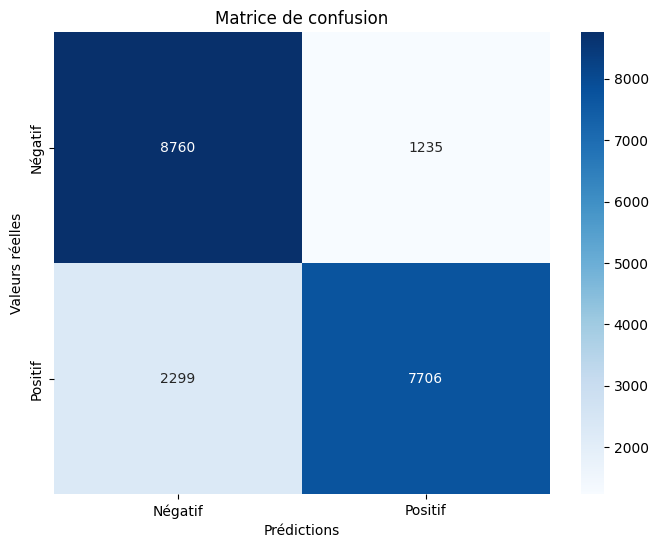

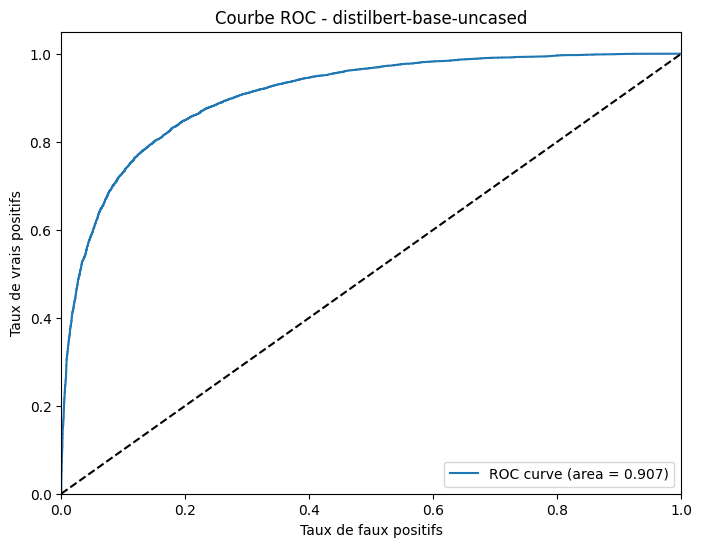

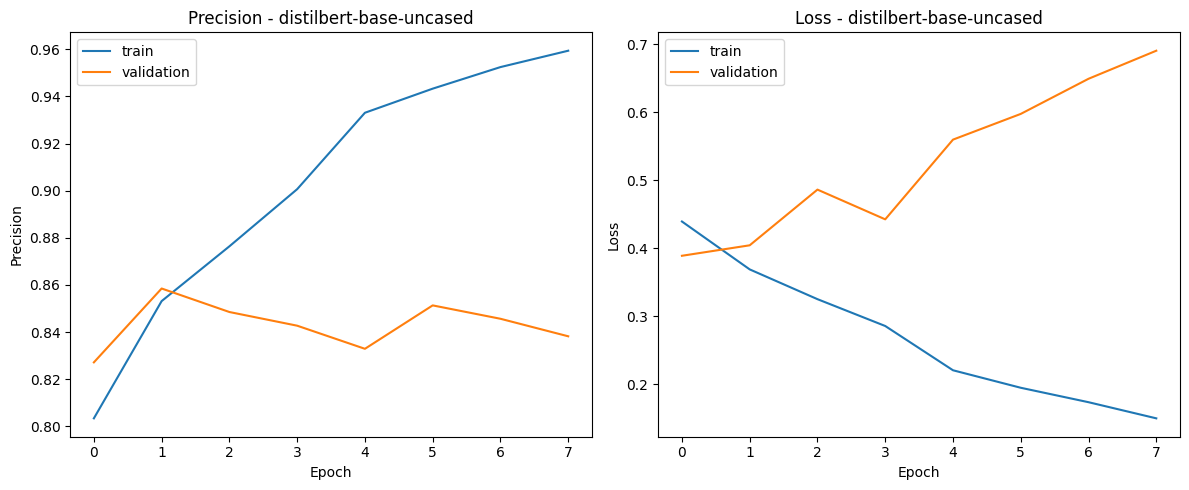

In [ ]:
# Entraîner le modèle
bert_pack = train_bert_sentiment(
    data_path=csv_file_path,
    model_name="distilbert-base-uncased",
    batch_size=16,
    epochs=20,
    sample_size=100000
)

## Chargement du modèle

In [ ]:
# FONCTION POUR CHARGER LE MODÈLE ENTRAINÉ
def load_bert_model(model_base_dir="content/bert-model"):
    """
    Charge le modèle BERT entraîné, le tokenizer et le preprocessor
    à partir de l'arborescence des artefacts sauvegardés.

    Args:
        model_base_dir (str): Répertoire de base contenant tous les artefacts du modèle
                             (par défaut: "content/bert-model")

    Returns:
        dict: Un dictionnaire contenant le modèle, le tokenizer et la fonction de prétraitement
    """
    # Définir les chemins des différents artefacts
    model_dir = os.path.join(model_base_dir, "model")
    tokenizer_dir = os.path.join(model_base_dir, "tokenizer")
    preprocessor_dir = os.path.join(model_base_dir, "preprocessor")
    preprocessor_file = os.path.join(preprocessor_dir, "preprocessor.pkl")

    # Charger le modèle
    try:
        model = DistilBertForSequenceClassification.from_pretrained(model_dir)
        print(f"Modèle chargé avec succès depuis '{model_dir}'")
    except Exception as e:
        print(f"Erreur lors du chargement du modèle : {e}")
        raise

    # Charger le tokenizer
    try:
        tokenizer = DistilBertTokenizer.from_pretrained(tokenizer_dir)
        print(f"Tokenizer chargé avec succès depuis '{tokenizer_dir}'")
    except Exception as e:
        print(f"Erreur lors du chargement du tokenizer : {e}")
        raise

    # Charger la fonction de prétraitement
    try:
        with open(preprocessor_file, "rb") as f_in:
            preprocess_tweet_for_bert = pickle.load(f_in)
        print(f"Fonction 'preprocess_tweet_for_bert' chargée avec succès depuis '{preprocessor_file}'")
    except FileNotFoundError:
        print(f"Erreur : Fichier preprocessor introuvable à l'emplacement '{preprocessor_file}'.")
        preprocess_tweet_for_bert = None
    except Exception as e:
        print(f"Erreur lors du chargement de la fonction de prétraitement : {e}")
        preprocess_tweet_for_bert = None

    # Vérifier si on a bien chargé la fonction de prétraitement
    if preprocess_tweet_for_bert is None:
        print("ATTENTION: Fonction de prétraitement non chargée. Les prédictions pourraient être affectées.")

    # Création d'un pack pour faciliter l'utilisation
    model_pack = {
        'model': model,
        'tokenizer': tokenizer,
        'preprocess': preprocess_tweet_for_bert
    }

    return model_pack

## Fonction de prédiction

In [ ]:
# FONCTION DE PRÉDICTION
def predict_sentiment(tweet, model_pack):
    """
    Prédit le sentiment d'un tweet à l'aide du modèle BERT
    """
    model = model_pack['model']
    tokenizer = model_pack['tokenizer']
    preprocess = model_pack['preprocess']

    # Prétraitement du tweet
    processed_tweet = preprocess(tweet)

    # Tokenisation
    encoding = tokenizer(
        processed_tweet,
        return_tensors="pt",
        truncation=True,
        padding=True,
        max_length=128
    )

    # Détection du device
    device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
    model = model.to(device)

    # Passer au mode évaluation
    model.eval()

    # Déplacer les tenseurs sur le device
    input_ids = encoding['input_ids'].to(device)
    attention_mask = encoding['attention_mask'].to(device)

    # Prédiction
    with torch.no_grad():
        outputs = model(input_ids=input_ids, attention_mask=attention_mask)
        logits = outputs.logits
        probabilities = torch.nn.functional.softmax(logits, dim=1)

    # Récupérer le sentiment prédit et le score de confiance
    predicted_class = torch.argmax(probabilities, dim=1).item()
    confidence_score = probabilities[0][predicted_class].item()
    raw_score = probabilities[0][1].item()  # Score de la classe positive

    # Convertir en étiquette lisible
    sentiment = "Positif" if predicted_class == 1 else "Négatif"

    # Résultat
    result = {
        'sentiment': sentiment,
        'confidence': confidence_score,
        'raw_score': raw_score
    }

    return result

## Test sur un ensemble de tweets

In [ ]:
# FONCTION DE TEST SUR ENSEMBLE DE TWEETS
def test_model_on_examples(model_pack, test_tweets):
    """
    Teste le modèle sur une liste de tweets et retourne un DataFrame avec les résultats des prédictions.
    """
    results = {
        "Positif": 0,
        "Négatif": 0
    }

    # Créer un DataFrame pour stocker les résultats
    predictions_data = []

    for i, tweet in enumerate(test_tweets):
        # Utiliser la fonction predict_sentiment avec model_pack
        result = predict_sentiment(tweet, model_pack)

        # Ajouter l'emoji approprié pour le sentiment
        emoji = "💚" if result['sentiment'] == "Positif" else "❌"

        # Ajouter les données au DataFrame
        predictions_data.append({
            "Tweet": tweet,
            "Sentiment": result['sentiment'],
            "Emoji": emoji,
            "Score de confiance": result['confidence'],
            "Score brut": result['raw_score'],
            "Index": i+1
        })

        # Comptage des résultats
        results[result['sentiment']] += 1

    # Créer le DataFrame
    df_predictions = pd.DataFrame(predictions_data)

    # Afficher un résumé
    print("\nTest du modèle sur les exemples:")
    print("="*50)
    print(f"Résumé: {len(test_tweets)} tweets analysés")
    print(f"Tweets positifs: {results['Positif']} ({(results['Positif']/len(test_tweets)*100):.1f}%)")
    print(f"Tweets négatifs: {results['Négatif']} ({(results['Négatif']/len(test_tweets)*100):.1f}%)")

    # Sauvegarder les résultats dans un fichier CSV
    os.makedirs('content/bert-model', exist_ok=True)
    df_predictions.to_csv("content/bert-model/predictions_results.csv", index=False)

    # Retourner le DataFrame
    return df_predictions

In [ ]:
# Liste améliorée de tweets pour tester le modèle
test_tweets_improved = [
    # Tweets positifs avec différentes caractéristiques
    "I absolutely love flying with @AirParadis! Their service is exceptional and the staff is always so friendly :) #bestairline #travel",
    "I just landed after an amazing flight... The crew was truly fantastic and the food was delicious! Can't wait to fly with them again :D",
    "Wow! You have to try @AirParadis. Best. Flight. Ever. Their new seats are incredibly comfortable. http://airparadis.com/newseats #travel #happy #AirParadis",
    "It was my first time flying business class, and I’m completely blown away!!! The service is definitely worth it... @AirParadis never lets me down :)",
    "What an incredible flight experience with @AirParadis! Everything was perfect from takeoff to landing. Would do it again in a heartbeat! #travel #satisfaction",

    # Tweets négatifs avec différentes caractéristiques
    "Honestly, my last flight with @AirParadis was disappointing. The flight was delayed without any notice. #disappointment",
    "I had high hopes for @AirParadis, but the seat was uncomfortable and the staff seemed overwhelmed during the flight. Not the best experience.",
    "So frustrated with @AirParadis this time. The staff was unresponsive and it ruined our trip. #nothappy",
    "The flight I booked with @AirParadis was canceled at the last minute. Very disappointing and no adequate communication!",
    "The quality of service with @AirParadis has declined. I expected better. It left a sour taste. #disappointed",

    # Tweets mixtes et nuancés
    "To be honest, @AirParadis has significantly improved their service since last year! Not perfect yet, but they are making an effort... #progress",
    "We were really looking forward to our trip, but our flight was delayed... at least the team was very apologetic and provided us with complimentary drinks! @AirParadis",
    "The flight with @AirParadis had great moments, but the delay somewhat tarnished the experience. I'll give them another chance!",
    "Overall, @AirParadis has good service, but I had a few minor issues with the check-in process. It could be better! #mixedfeelings",
    "While our flight was pleasant, the lack of communication regarding the schedule was a bit frustrating. @AirParadis can do better. #nuanced"
]

# Charger le modèle entraîné
model_pack = load_bert_model()

# Tester le modèle sur les exemples
df_results = test_model_on_examples(model_pack, test_tweets_improved)

print("Analyse de sentiment terminée! Résultats disponibles dans content/bert-model/predictions_results.csv")

Modèle chargé avec succès depuis 'content/bert-model/model'
Tokenizer chargé avec succès depuis 'content/bert-model/tokenizer'
Fonction 'preprocess_tweet_for_bert' chargée avec succès depuis 'content/bert-model/preprocessor/preprocessor.pkl'

Test du modèle sur les exemples:
Résumé: 15 tweets analysés
Tweets positifs: 7 (46.7%)
Tweets négatifs: 8 (53.3%)
Analyse de sentiment terminée! Résultats disponibles dans content/bert-model/predictions_results.csv


In [ ]:
df_results

,Tweet,Sentiment,Emoji,Score de confiance,Score brut,Index
0,I absolutely love flying with @AirParadis! The...,Positif,💚,0.941539,0.941539,1
1,I just landed after an amazing flight... The c...,Positif,💚,0.949552,0.949552,2
2,Wow! You have to try @AirParadis. Best. Flight...,Positif,💚,0.960181,0.960181,3
3,"It was my first time flying business class, an...",Négatif,❌,0.950030,0.049970,4
4,What an incredible flight experience with @Air...,Positif,💚,0.965208,0.965208,5
5,"Honestly, my last flight with @AirParadis was ...",Négatif,❌,0.987460,0.012539,6
6,"I had high hopes for @AirParadis, but the seat...",Négatif,❌,0.984469,0.015531,7
7,So frustrated with @AirParadis this time. The ...,Négatif,❌,0.975684,0.024316,8
8,The flight I booked with @AirParadis was cance...,Négatif,❌,0.988538,0.011462,9
9,The quality of service with @AirParadis has de...,Négatif,❌,0.987166,0.012834,10


In [ ]:
# Liste améliorée de tweets pour tester le modèle
unambiguous_tweets = [
    # --- Strongly Positive ---
    "@AirParadis offers absolutely FLAWLESS service! Best airline, period. I recommend it 1000%! 😍 #DreamTrip",
    "PERFECT flight with @AirParadis today. Amazing staff, clean plane, arrived early. What more could you ask for? ⭐⭐⭐⭐⭐ #HappyCustomer",
    "I'm totally a fan of @AirParadis! Every flight is a pleasure. Comfort, kindness, punctuality... they have it all! Thank you! 😊✈️",
    "Extraordinary experience in business class on @AirParadis. Worth every penny. Luxury and attention to detail. WELL DONE! 👏 #LuxuryTravel",
    "@AirParadis saved my vacation! After a cancellation with another airline, they immediately found me a seat. Top-notch customer service! 🙏 #Saved",

    # --- Strongly Negative ---
    "AVOID @AirParadis! The worst customer service I've ever seen. Rude, incompetent, and they lost my luggage! An absolute disgrace. 😠 #AirlineToAvoid",
    "DISASTROUS flight with @AirParadis. 5-hour delay, no information, unfriendly staff. NEVER flying with them again. 🤬 #TripRuined",
    "How can @AirParadis dare to charge for seats that are so dirty and uncomfortable? It's outright theft. Horrible airline. 👎 #Scam",
    "@AirParadis let me down. Flight canceled for no valid reason, no solution offered. Zero service. I'm disgusted. 😤 #Abandoned",
    "The food served on @AirParadis was simply inedible. Cold, tasteless... I've never eaten anything so bad on a flight. 🤢 #AirplaneFood"
]

# Charger le modèle entraîné
# Assurez-vous que la fonction load_bert_model est définie et fonctionnelle
model_pack = load_bert_model()

# Tester le modèle sur les exemples
# Assurez-vous que la fonction test_model_on_examples est définie,
# prend le model_pack et la liste de tweets, et renvoie un DataFrame
df_results = test_model_on_examples(model_pack, unambiguous_tweets)

# Afficher un message indiquant où trouver les résultats (si sauvegardés par la fonction)
print("Analyse de sentiment terminée! Vérifiez si les résultats sont dans content/bert-model/predictions_results.csv")

# Optionnel : Afficher les premières lignes du DataFrame résultant
df_results

Modèle chargé avec succès depuis 'content/bert-model/model'
Tokenizer chargé avec succès depuis 'content/bert-model/tokenizer'
Fonction 'preprocess_tweet_for_bert' chargée avec succès depuis 'content/bert-model/preprocessor/preprocessor.pkl'

Test du modèle sur les exemples:
Résumé: 10 tweets analysés
Tweets positifs: 5 (50.0%)
Tweets négatifs: 5 (50.0%)
Analyse de sentiment terminée! Vérifiez si les résultats sont dans content/bert-model/predictions_results.csv


,Tweet,Sentiment,Emoji,Score de confiance,Score brut,Index
0,@AirParadis offers absolutely FLAWLESS service...,Positif,💚,0.964295,0.964295,1
1,PERFECT flight with @AirParadis today. Amazing...,Positif,💚,0.935371,0.935371,2
2,I'm totally a fan of @AirParadis! Every flight...,Positif,💚,0.976377,0.976377,3
3,Extraordinary experience in business class on ...,Positif,💚,0.969083,0.969083,4
4,@AirParadis saved my vacation! After a cancell...,Positif,💚,0.911861,0.911861,5
5,AVOID @AirParadis! The worst customer service ...,Négatif,❌,0.978022,0.021978,6
6,DISASTROUS flight with @AirParadis. 5-hour del...,Négatif,❌,0.976990,0.023010,7
7,How can @AirParadis dare to charge for seats t...,Négatif,❌,0.977153,0.022847,8
8,@AirParadis let me down. Flight canceled for n...,Négatif,❌,0.986005,0.013995,9
9,The food served on @AirParadis was simply ined...,Négatif,❌,0.634308,0.365692,10


# Enregistrement de dépendances

In [ ]:
!pip freeze > requirements_bert.txt